In [1]:
%%bash

pip3 install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [47]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima


############ 데이터 불러오기 ############

# df = pd.read_csv('/content/dataset.csv',index_col=False,skiprows=0)
df = pd.read_csv('/content/supermarket_sales.csv') # 오류시 붙여줘야함


############ 데이터 살펴보기 ############


# print(df)
# print(df.iloc[0])

# Invoice ID                       750-67-8428
# Branch                                     A
# City                                  Yangon
# Customer type                         Member
# Gender                                Female
# Product line               Health and beauty
# Unit price                             74.69
# Quantity                                   7
# Tax 5%                               26.1415
# Total                               548.9715
# Date                                1/5/2019
# Time                                   13:08
# Payment                              Ewallet
# cogs                                  522.83
# gross margin percentage             4.761905
# gross income                         26.1415
# Rating                                   9.1
# Name: 0, dtype: object


# 데이터 확인
# print(df.info())
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 1000 entries, 0 to 999
# Data columns (total 17 columns):
#  #   Column                   Non-Null Count  Dtype  
# ---  ------                   --------------  -----  
#  0   Invoice ID               1000 non-null   object 
#  1   Branch                   1000 non-null   object 
#  2   City                     1000 non-null   object 
#  3   Customer type            1000 non-null   object 
#  4   Gender                   1000 non-null   object 
#  5   Product line             1000 non-null   object 
#  6   Unit price               1000 non-null   float64
#  7   Quantity                 1000 non-null   int64  
#  8   Tax 5%                   1000 non-null   float64
#  9   Total                    1000 non-null   float64
#  10  Date                     1000 non-null   object 
#  11  Time                     1000 non-null   object 
#  12  Payment                  1000 non-null   object 
#  13  cogs                     1000 non-null   float64
#  14  gross margin percentage  1000 non-null   float64
#  15  gross income             1000 non-null   float64
#  16  Rating                   1000 non-null   float64
# dtypes: float64(7), int64(1), object(9)
# memory usage: 132.9+ KB
# None

#컬럼명 변경
df.rename(columns={
    'Invoice ID':'invoice_id',
    'Branch':'branch',
    'City':'city',
    'Customer type':'customer_type',
    'Gender':'gender',
    'Product line':'product_line',
    'Unit price':'unit_price',
    'Quantity':'quantity',
    'Tax 5%':'tax_5p',
    'Total':'total',
    'Date':'date',
    'Time':'time',
    'Payment':'payment',
    'gross margin percentage':'gross_margin_percentage',
    'gross income':'gross_income',
    'Rating':'rating'
},inplace=True)


# # 컬럼명 변경
# # print(df.columns)
# # Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')
# df.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60':'passengers'},inplace=True)
# df.rename(columns={'Month':'month'},inplace=True)


# df.isna().sum() # 널값 없음

# # 결측값 제거
# df.dropna(axis=0, inplace=True)

# 날짜형 데이터로 변환
df['date'] = pd.to_datetime(df['date'])


df_1 = df.groupby('date')[['date','total']].sum()
# df_1.set_index('date',inplace=True)

# print(df_1.index)
# print(df_1.values)

# x = df_1.index
# y = df_1.values

# # # 날짜형 데이터로 변환
# # df['month'] = pd.to_datetime(df['month'])
# # # 날짜 데이터 인덱스 설정
# # df.set_index('month',inplace=True)

# # 데이터 흐름 시각화
# plt.plot(x,y)
# plt.show()

data = df_1


DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
      

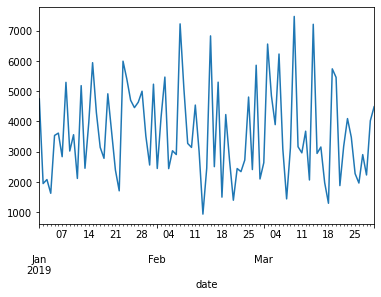

In [31]:
# 시각화
fig = data.plot()


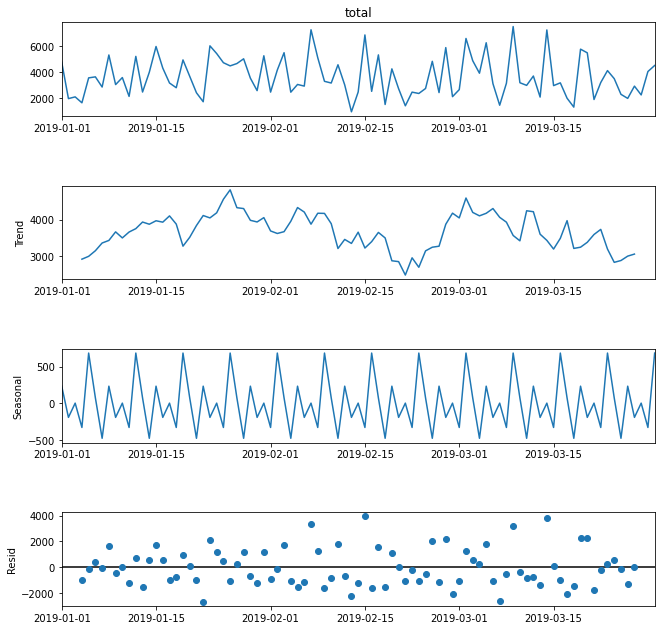

In [48]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages.

# Observed : observed data 관측 데이터
# Trend : The estimated trend component 추세
# Seasonal : The estimated seasonal component 계절적
# resid : The estimated residuals 잔차


# 시즈널 디컴퍼즈 나눔 
decomposition = sm.tsa.seasonal_decompose(data['total'], model='additive') # period=1 옵션은 실행이 안되서 제외
# decomposition = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1) 
fig = decomposition.plot() #
fig.set_size_inches(10,10) #크기 지정
plt.show()



In [61]:
## 트레인 데이터, 테스트 데이터 분리

train_data,test_data = train_test_split(data,test_size=0.2,shuffle=False) 
#shuffle을 False로 두면 랜덤하게 섞이지 않는다/시계열이므로 

print(test_data)

                total
date                 
2019-03-13  2063.6070
2019-03-14  7214.6340
2019-03-15  2942.4150
2019-03-16  3154.4730
2019-03-17  1976.2890
2019-03-18  1292.8335
2019-03-19  5740.3920
2019-03-20  5458.2045
2019-03-21  1877.5155
2019-03-22  3179.1480
2019-03-23  4095.0420
2019-03-24  3477.4635
2019-03-25  2272.9665
2019-03-26  1962.5130
2019-03-27  2902.8195
2019-03-28  2229.4020
2019-03-29  4023.2430
2019-03-30  4487.0595


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


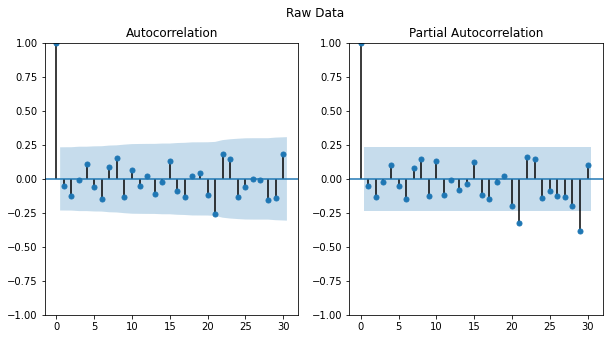

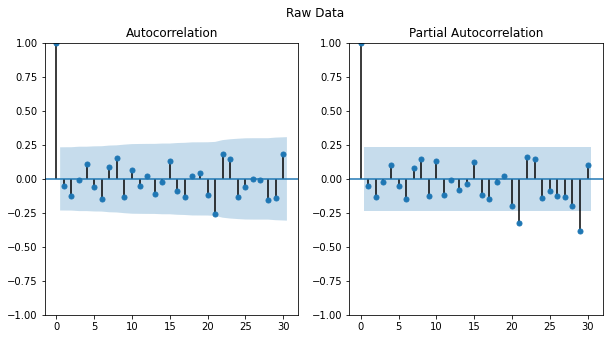

In [50]:
# ACF, PACF plot

# auto correlation function
# partial auto correlation function

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])


# ACF non-stationary 한 데이터임을 확인
# lag가 0일때는 무조건 1
# 천천히 떨어지면 non-stationary 대표
# stationary의 경우 lag기준 빠르게 떨어지던지, 패턴이 없음



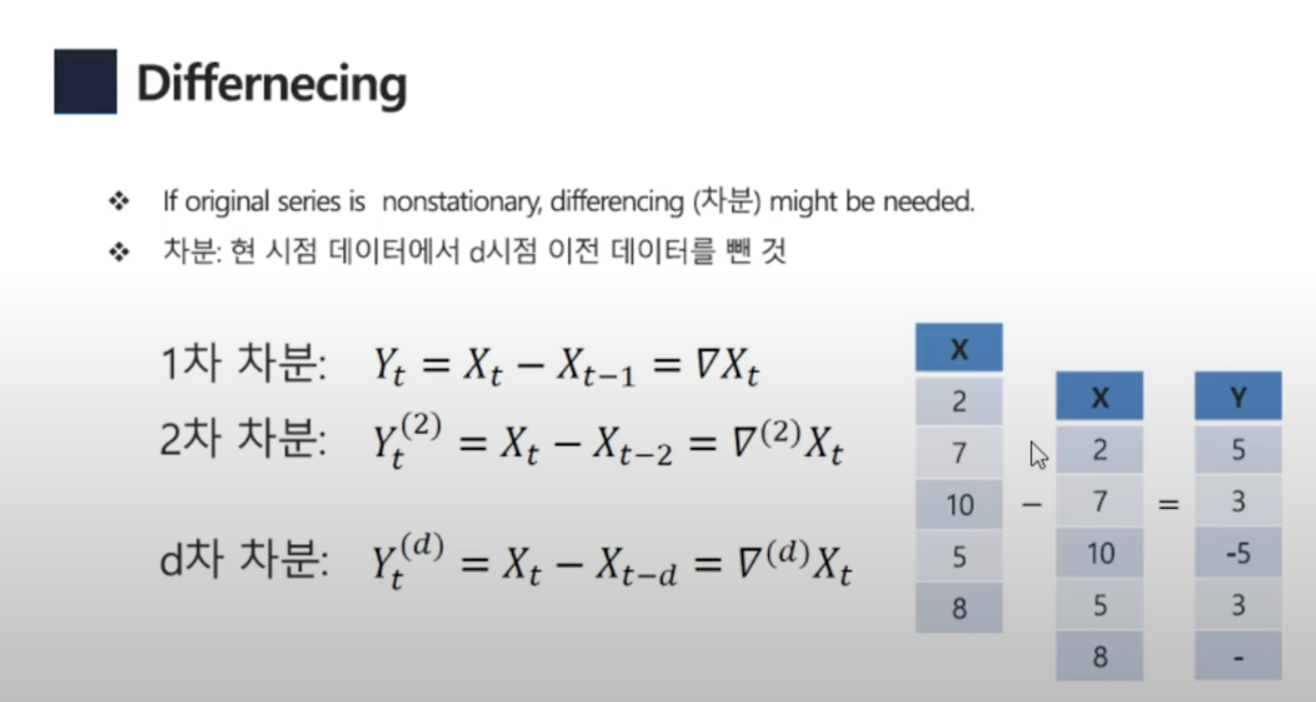

In [52]:
# stationary 하게 데이터를 보정
# 차분

diff_train_data = train_data.copy() #차분을 진행할 데이터 셋
diff_train_data = diff_train_data['total'].diff() #차분 진행
diff_train_data = diff_train_data.dropna() # 차분 진행이후 맨 마지막 열은 null이 되므로 제외


print(train_data)
print(diff_train_data)


                total
date                 
2019-01-01  4745.1810
2019-01-02  1945.5030
2019-01-03  2078.1285
2019-01-04  1623.6885
2019-01-05  3536.6835
...               ...
2019-03-08  3125.3880
2019-03-09  7474.0470
2019-03-10  3163.2300
2019-03-11  2961.2520
2019-03-12  3677.5515

[71 rows x 1 columns]
date
2019-01-02   -2799.6780
2019-01-03     132.6255
2019-01-04    -454.4400
2019-01-05    1912.9950
2019-01-06      77.5215
                ...    
2019-03-08    1687.1295
2019-03-09    4348.6590
2019-03-10   -4310.8170
2019-03-11    -201.9780
2019-03-12     716.2995
Name: total, Length: 70, dtype: float64


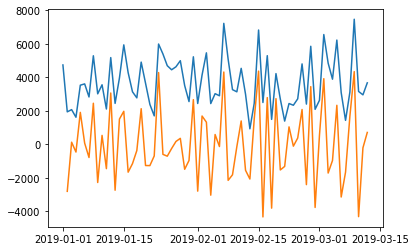

In [53]:
plt.plot(train_data)
plt.plot(diff_train_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


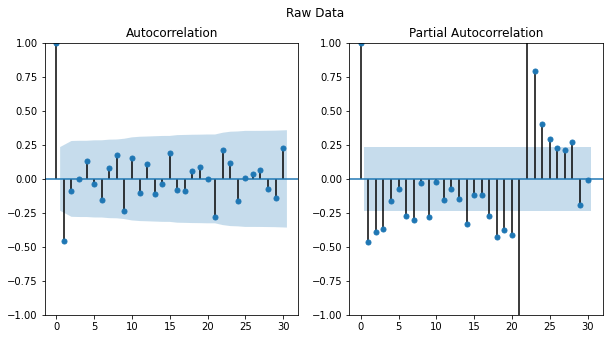

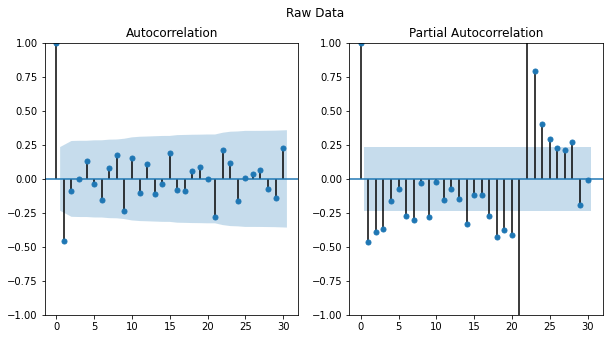

In [54]:
# 1차 차분된 데이터를 토대로 ACF, PACF plot

# auto correlation function
# partial auto correlation function

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])



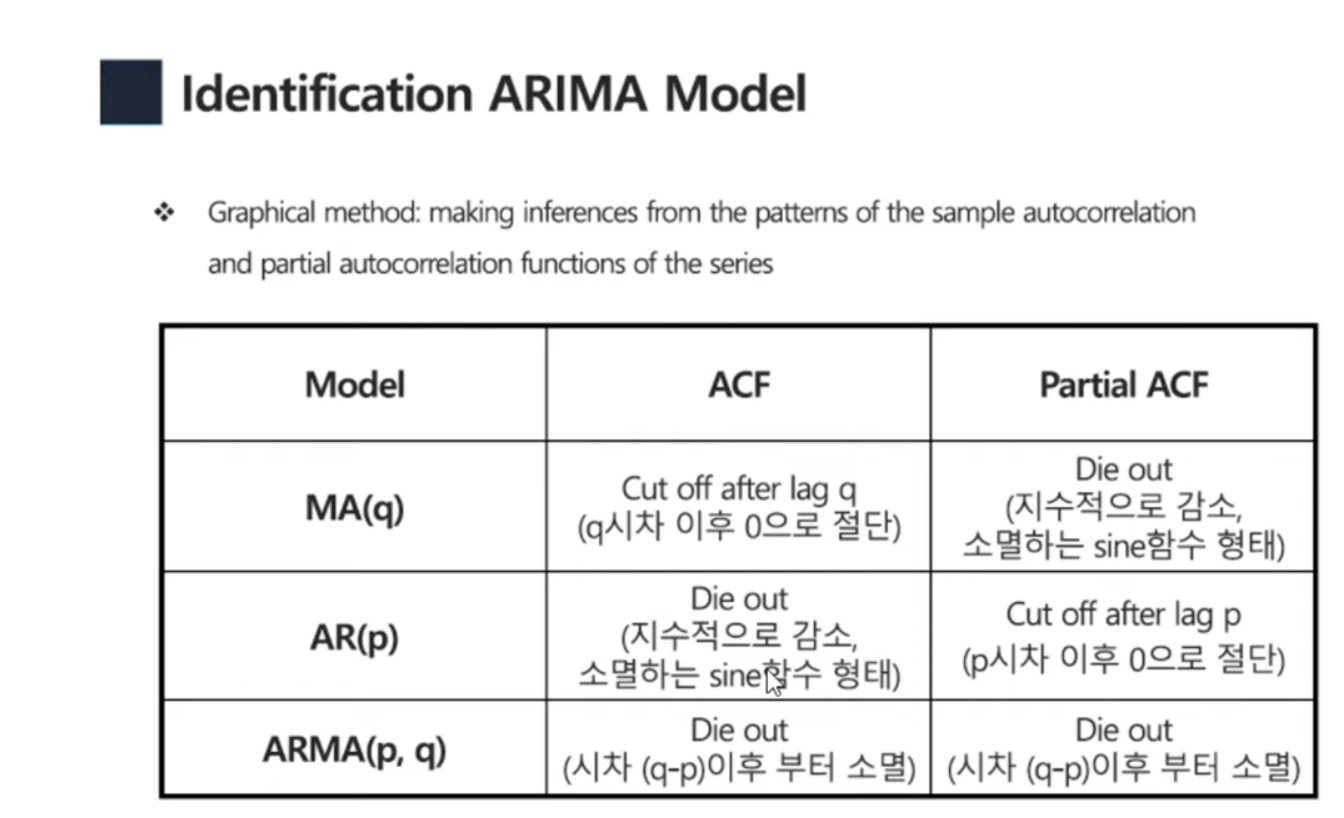

In [55]:
################################################ ARIMA 모델 도입
# the (p,d,q) order of the model for the mumber of AR parameters, differncesm and MA parameters to use.
# order 
# p는 AR 항의 차수입니다. 
# d는 시계열 안정성을 만들기 위한 미분 차수 입니다. (diff)
# q는 MA 항의 차수입니다. 

model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()


NotImplementedError: ignored

In [ ]:
import itertools
# parameter search

p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic=[]

for i in pdq:
  model = ARIMA(train_data.values, order=(i))
  model_fit = model.fit()
  print(f'ARIMA : {i} >> AIC : {round(model_fit.aic,2)}')
  aic.append(round(model_fit.aic,2))

# ARIMA : (2, 1, 1) >> AIC : 1045.66 가장 낮은 스코어가 좋음


ARIMA : (0, 1, 0) >> AIC : 1076.52
ARIMA : (0, 1, 1) >> AIC : 1064.62
ARIMA : (0, 1, 2) >> AIC : 1061.08
ARIMA : (1, 1, 0) >> AIC : 1069.44
ARIMA : (1, 1, 1) >> AIC : 1058.83
ARIMA : (1, 1, 2) >> AIC : 1046.05
ARIMA : (2, 1, 0) >> AIC : 1066.2
ARIMA : (2, 1, 1) >> AIC : 1045.66
ARIMA : (2, 1, 2) >> AIC : 1047.19


In [ ]:
################################################ ARIMA 모델 도입
# the (p,d,q) order of the model for the mumber of AR parameters, differncesm and MA parameters to use.
# order 
# p : 
# d : 차분 1
# q : 

model = ARIMA(train_data.values, order=(2,1,1))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Wed, 20 Jul 2022   AIC                           1045.660
Time:                        06:33:20   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.162     15.754      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [56]:
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1,D=1,
                              max_P=3,max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False
)

#파라미터를 지정해두면 자동으로 찾아주는 프로그램 pmdarima install
# start_p : p값의 최소값 (1,3)
# start_q : q값의 최소값 (1,3)
# max_p : p값의 최대값 (1,3)
# max_q : q값의 최대값 (1,3)
# m : 계절성을 의미, 월별 계절성이면 12, 분기별인 경우는 4
# 나머지는 정의 안해줘도 가능

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1090.769, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1087.562, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=2.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1081.286, Time=0.22 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=3.08 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1080.536, Time=0.54 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=2.74 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1058.19

In [57]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   71
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -518.540
Date:                             Wed, 20 Jul 2022   AIC                           1047.080
Time:                                     09:09:34   BIC                           1057.382
Sample:                                          0   HQIC                          1051.093
                                              - 71                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9389      0.112     -8.395      0.000      -1.158      -0.720
ar.S.L12      -0.6331      0.133     -4.759      0.000      -0.894      -0.372
ar.S.L24      -0.5651      0.184     -3.079      0.002      -0.925      -0.205
ar.S.L36      -0.3931      0.172     -2.283      0.022      -0.731      -0.056
sigma2      2.865e+06    7.7e+05      3.722      0.000    1.36e+06    4.37e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.62   Prob(JB):                         0.06
Heteroskedasticity (H):               1.71   Skew:                             0.77
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# 예측

prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data,predicted_value)

In [64]:
print(prediction)

(array([4213.42958288, 5098.0092513 , 5305.20774414, 4551.50319918,
       5150.88758872, 3465.03149137, 2715.23444242, 4146.27489513,
       4432.47476312, 3615.96406377, 5050.75715275, 3123.17566516,
       4069.71737429, 3957.57892113, 6086.88611019, 4640.77064637,
       4081.07631441, 3378.0829397 ]), array([[ 892.55345877, 7534.30570699],
       [1770.9574906 , 8425.06101199],
       [1971.9917888 , 8638.42369949],
       [1212.13442775, 7890.87197061],
       [1805.37731699, 8496.39786045],
       [ 113.39097293, 6816.67200982],
       [-642.5251308 , 6072.99401563],
       [ 782.40739802, 7510.14239225],
       [1062.51041245, 7802.43911379],
       [ 239.91386992, 6992.01425763],
       [1668.63206664, 8432.88223886],
       [-265.01342116, 6511.36475149],
       [ 393.25020864, 7746.18453993],
       [ 270.69374341, 7644.46409885],
       [2389.61227569, 9784.15994468],
       [ 933.13726363, 8348.40402911],
       [ 363.11224863, 7799.04038018],
       [-350.18318384, 7106.3

Text(0.5, 0.98, 'SARIMA (0, 1, 1),(3, 1, 0, 12) Prediction Results (r2 Score : -0.77)')

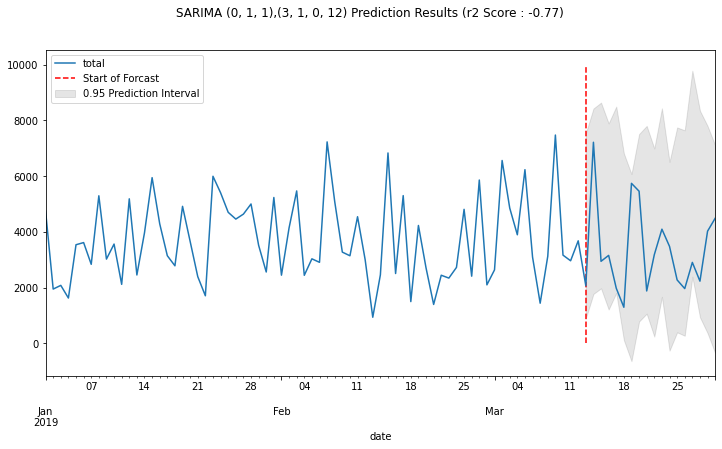

In [65]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
ax.vlines('2019-03-13',0,10000, linestyle='--',color='r',label='Start of Forcast')
ax.fill_between(predict_index,predicted_lb,predicted_ub, color='k',alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2 Score : {round(r2,2)})')



# 만약 r2값이 음수가 나온다면 데이터가 arbitrarily한 경우이거나, 독립 변수의 일괄 평균으로 예측하는 것보다 성능이 떨어진다는 것을 의미한다.

In [ ]:
# prediction = model_opt_fit.forecast(len(test_data))
# prediction_value = prediction[0]
# prediction_ub = prediction[2][:,0]
# prediction_lb = prediction[2][:,1]
# predict_index = list(test_data.index)
# r2 = r2_score(test_data,predicted_value)

실제 데이터와 최근 5달의 값을 비교